In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

# Application of EPIC to (relatively) sparse arrays

We have recognized that a major limitation to the MOFF algorithm is that it works for very dense array, but is very inefficient for sparse arrays. There are a few ideas to remedy this:

- Use sparse FFTs directly (https://groups.csail.mit.edu/netmit/sFFT/index.html)
  - The website above focuses on sparse _output_. It's not clear if there is a sparse input version. Need to dig deeper.
  - They do say they have developed a radio astronomy application for SKA. But they don't link any publication.
- Use hierarchical gridding with transformations (a la omniscope; https://journals.aps.org/prd/abstract/10.1103/PhysRevD.82.103501)
  - The key here would be to place a small grid around every element, and hierarchically grid those grids.
  - I showed this idea a while back in an evernote note. Will need to revive it.
  - One point that stands out to me, which is a feature of omniscope as well, is that it doesn't look like it's strictly NlogN. It looks like the benefit you gain is inversely proportional to the number of hierarchy steps required.
- log-FFTs (https://jila.colorado.edu/~ajsh/FFTLog/)
- direct FT outliers to the output grid
  - To get the benefit of the outriggers, I think we would need a super-sampled output grid. This may mean we need to pad the input anyway, in which case we should have just used the outriggers as usual.
  - However, there may be a way to use NxN input with 2Nx2N output, or even get NxN output and interpolate.
  - focus on pixels of interest? Is that just beamforming?
    - instead: writing down/buffer voltages of outriggers to investigate small region if you trigger on interesting event
- calculate visibilities of outliers x all other antennas. Inject these into uv plane after the fact.
  - Would require step where we FT image back to uv, pad, add new visibilities, and FT back to image.
- ... I'm sure there are more ideas out there.

A reasonable place to start is to come up with a computation cost model for the different solutions.

In [33]:
class TelescopeObservation():
    """ A class which defines a telescope and observations parameters
    (e.g. frequency, bandwidth, integration, etc)
    """
    
    def __init__(self, layout=None, Nant=None, Darray=None, Dant=None, grid_size=None, f0=None,
                 bandwidth=None, Nchan=None, integration=None, in_bit_depth=4, out_bit_depth=32):
        """ Initialize the class
        
        Parameters
        ----------
        layout : array of floats, optional
            (Nant, 2 or 3) Array of antenna locations in meters. If Nant and Darray are not set,
            layout will be used to determine them.
        Nant : int
            Number of antennas in the array. If layout is also set, Nant will be set to
            min(Nant, layout.shape[0]). If layout has more antennas than Nant, the first Nant will be used.
        Darray : float
            Diameter of the array in meters. If layout is also set, Darray will be set to
            to either this argument or the Darray determined from the layout, whichever is smaller.
        Dant : float
            Diameter of the antennas in meters.
        grid_size : float
            Size of grid elements in wavelengths.
        f0 : float or int
            Center frequency in MHz.
        bandwidth : float
            Bandwidth in MHz
        Nchan : int
            Number of frequency channels.
        integration : float
            Integration time for output data, in seconds.
        in_bit_depth : int
            Number of bits per sample of input. Default is 4 (x2 for complex).
        out_bit_depth : int
            Number of bits per sample output. Default is 32.
        """
        self.layout = layout
        if self.layout is not None:
            # center the array about zero
            self.layout -= np.mean(self.layout, axis=0).reshape(1, 2)
            # find diameter of array
            rs = np.sqrt(np.sum(np.abs(self.layout)**2, axis=1))
            max_u = 2 * np.max(rs)
            if Darray is None:
                self.Darray = max_u
            else:
                self.Darray = np.min([max_u, Darray])
            # Remove antennas outside radius
            if self.Darray < max_u:
                inds = np.where(2 * rs > self.Darray)[0]
                self.layout = np.delete(self.layout, inds, axis=0)
            if Nant is None:
                self.Nant = self.layout.shape[0]
            else:
                self.Nant = np.min([Nant, self.layout.shape[0]])
                self.layout = self.layout[:self.Nant]
        else:
            self.Nant = Nant
            self.Darray = Darray
        
        self.Dant = Dant
        self.grid_size = grid_size
        self.f0 = f0
        self.bandwidth = bandwidth
        self.Nchan = Nchan
        self.integration = integration
        self.in_bit_depth = in_bit_depth
        self.out_bit_depth = out_bit_depth
        
        self._set_dependents()
        
    def _set_dependents(self):
        # Some calculated values that are useful
        complex_factor = 2.
        bits_per_byte = 8.
        
        self.in_bw = (self.Nant * self.bandwidth * self.in_bit_depth
                      * complex_factor / bits_per_byte)  # MBps
        self.lambda0 = const.speed_of_light / (self.f0 * 1e-6)
        self.channels = np.linspace(self.f0 - self.bandwidth / 2,
                                    self.f0 + self.bandwidth / 2, num=Nchan)  # MHz
        self.lambdas = const.speed_of_light / (self.channels * 1e6)
        self.cadence = 1. / (bandwidth / Nchan * 1e6)  # Time per FFT in seconds
        
    def vanilla_EPIC_stats(self, padding=2, verbose=True):
        """ Calculate the computation requirement for Vanilla EPIC.

        Parameters
        ----------
        padding : float or int, optional
            Factor to pad grid. Default is 2, which will make the same size
            grid as no padding FX.
        verbose : bool
            Option to print more stats than just what is returned.

        Returns
        -------
        total_flops : float
            Number of floating point operations per second required to process the data.
        """
        max_u = self.Darray * (self.f0 + self.bandwidth / 2.) * 1e6 / const.speed_of_light
        npix = padding * 2 ** (np.ceil(np.log2(max_u / self.grid_size)))  # pixels per side

        gridding_flops_per_chan = self.Nant * (self.Dant / self.lambdas / self.grid_size)**2 / self.cadence

        fft_flops_per_chan = 5 * npix * np.log2(npix) / self.cadence

        # TODO: add squaring, averaging
        # TODO: output bandwidth
        # TODO: report FoV and resolution

        total_flops = np.sum(gridding_flops_per_chan) + fft_flops_per_chan * self.Nchan

        if verbose:
            print('Input bandwidth = ' + str(self.in_bw) + ' MBps')
            print('Npix = ' + str(npix))
            print('Cadence = ' + str(self.cadence) + ' s')
            print('Gridding GFLOPS per channel (avg) = ' + str(np.mean(gridding_flops_per_chan * 1e-9)))
            print('Total gridding GFLOPS = ' + str(np.sum(gridding_flops_per_chan * 1e-9)))
            print('FFT GFLOPS per channel = ' + str(fft_flops_per_chan * 1e-9))
            print('Total FFT GFLOPS = ' + str(fft_flops_per_chan * self.Nchan * 1e-9))
            print('All the GFLOPS = ' + str(1e-9 * total_flops))

        return total_flops
    
    def FX_stats(self, padding=1, verbose=True):
        """ Calculate the computation requirement for FX correlator + image.

        Parameters
        ----------
        padding : float or int, optional
            Factor to pad grid. Default is 1 (no padding).
        verbose : bool
            Option to print more stats than just what is returned.

        Returns
        -------
        total_flops : float
            Number of floating point operations per second required to process the data.
        """
        
        nbls = self.Nant * (self.Nant - 1.) / 2.
        corr_flops_per_channel = nbls / self.cadence
        
        max_u = self.Darray * (self.f0 + self.bandwidth / 2.) * 1e6 / const.speed_of_light
        npix = 2 * padding * 2 ** (np.ceil(np.log2(max_u / self.grid_size)))  # pixels per side
        
        gridding_flops_per_chan = self.Nant * (2 * self.Dant / self.lambdas / self.grid_size)**2 / self.integration
        fft_flops_per_chan = 5 * npix * np.log2(npix) / self.integration
        
        total_flops = self.Nchan * (corr_flops_per_channel + gridding_flops_per_chan.mean() + fft_flops_per_chan)
        
        if verbose:
            print('Input bandwidth = ' + str(self.in_bw) + ' MBps')
            print('Npix = ' + str(npix))
            print('Cadence = ' + str(self.cadence) + ' s')
            print('Corr GFLOPS per channel = ' + str(corr_flops_per_channel * 1e-9))
            print('Gridding GFLOPS per channel (avg) = ' + str(np.mean(gridding_flops_per_chan * 1e-9)))
            print('Total gridding GFLOPS = ' + str(np.sum(gridding_flops_per_chan * 1e-9)))
            print('FFT GFLOPS per channel = ' + str(fft_flops_per_chan * 1e-9))
            print('Total FFT GFLOPS = ' + str(fft_flops_per_chan * self.Nchan * 1e-9))
            print('All the GFLOPS = ' + str(1e-9 * total_flops))

        return total_flops
    
    def plot_layout(self):
        plt.plot(self.layout[:, 0], self.layout[:, 1], 'o')
        plt.axes().set_aspect('equal', 'datalim')

In [3]:
Nant = 256
Darray = 100  # m
Dant = 3  # m
grid_size = .5  # wavelengths
f0 = 74  # MHz
bandwidth = 10. # MHz
Nchan = 1024
integration = 1  # s

np.random.seed(13)
layout = 100 * np.random.randn(150, 2)
test = TelescopeObservation(Nant=Nant, Darray=Darray, Dant=Dant, grid_size=grid_size,
                            f0=f0, bandwidth=bandwidth,  Nchan=Nchan, integration=integration)

In [4]:
test.vanilla_EPIC_stats()
print('\n')
test.FX_stats()

Input bandwidth = 2560.0 MBps
Npix = 128.0
Cadence = 0.0001024 s
Gridding GFLOPS per channel (avg) = 0.00549194572619
Total gridding GFLOPS = 5.62375242362
FFT GFLOPS per channel = 0.04375
Total FFT GFLOPS = 44.8
All the GFLOPS = 50.4237524236


Input bandwidth = 2560.0 MBps
Npix = 128.0
Cadence = 0.0001024 s
Corr GFLOPS per channel = 0.31875
Gridding GFLOPS per channel (avg) = 2.24950096945e-06
Total gridding GFLOPS = 0.00230348899272
FFT GFLOPS per channel = 4.48e-06
Total FFT GFLOPS = 0.00458752
All the GFLOPS = 326.406891009


326406891008.99274

In [5]:
dsa_layout = np.loadtxt('layouts/dsa_5m_15km.txt')

In [58]:
Nant = 2045
Darray = 2000  # m
Dant = 5  # m
grid_size = 2  # wavelengths
f0 = 1.35e3  # MHz
bandwidth = 1.3e3 # MHz
Nchan = 1024
integration = 1  # s

dsa_layout = np.loadtxt('layouts/dsa_5m_15km.txt')
dsa = TelescopeObservation(layout=dsa_layout, Dant=Dant, grid_size=grid_size,
                           f0=f0, bandwidth=bandwidth,  Nchan=Nchan, integration=integration)
dsa_center = TelescopeObservation(layout=dsa_layout, Dant=Dant, Darray=Darray, grid_size=grid_size,
                                  f0=f0, bandwidth=bandwidth,  Nchan=Nchan, integration=integration)

<IPython.core.display.Javascript object>


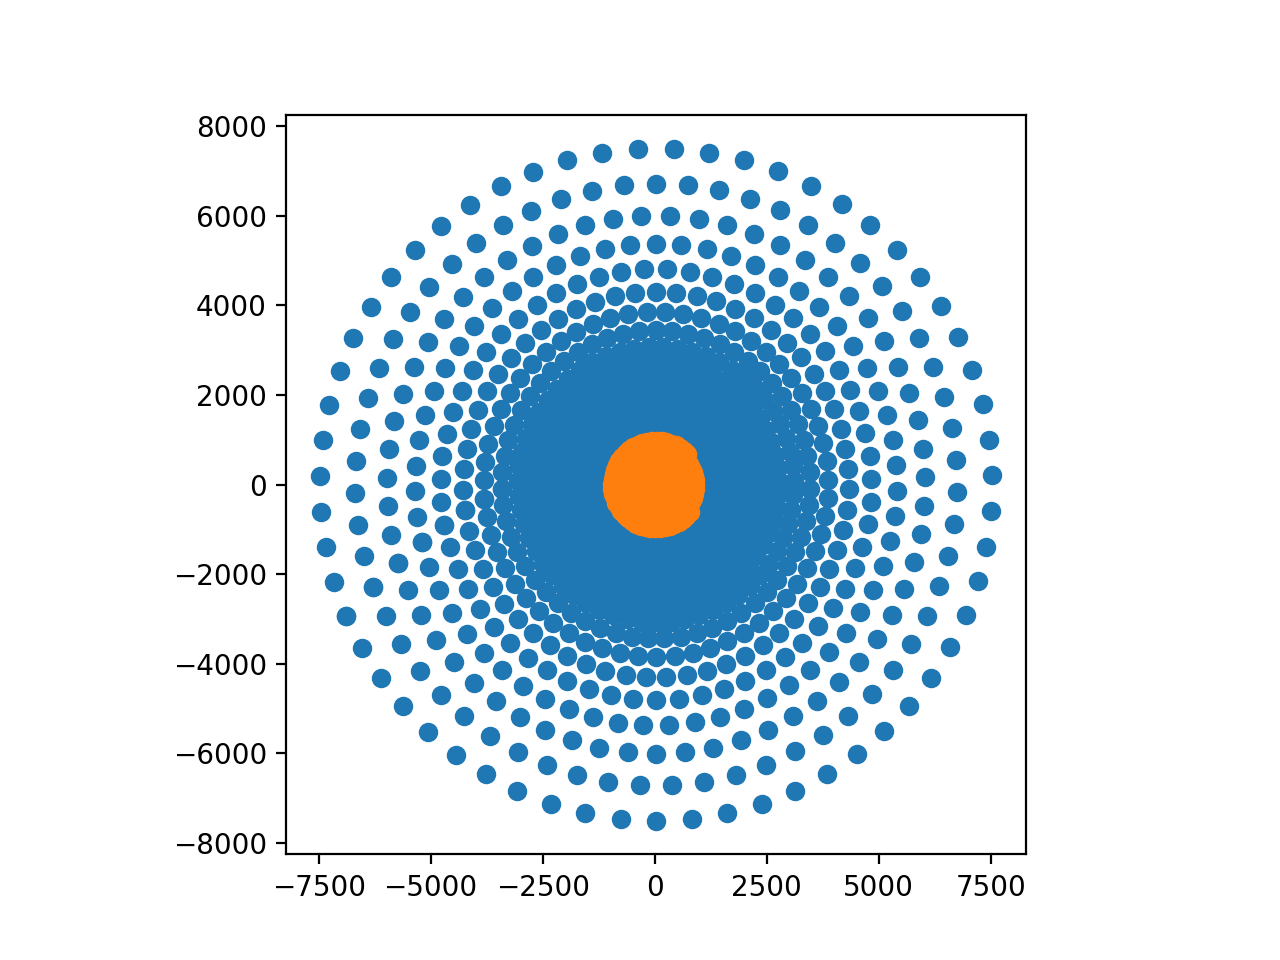

In [45]:
plt.figure()
plt.plot(dsa.layout[:, 0], dsa.layout[:, 1], 'o')
plt.plot(dsa_center.layout[:, 0], dsa_center.layout[:, 1], 'o')
plt.gca().set_aspect('equal')

In [42]:
dsa.vanilla_EPIC_stats()
print('\n')
dsa.FX_stats()

Input bandwidth = 2658500.0 MBps
Npix = 131072.0
Cadence = 7.87692307692e-07 s
Gridding GFLOPS per channel (avg) = 354.511444547
Total gridding GFLOPS = 363019.719216
FFT GFLOPS per channel = 14144.0
Total FFT GFLOPS = 14483456.0
All the GFLOPS = 14846475.7192


Input bandwidth = 2658500.0 MBps
Npix = 131072.0
Cadence = 7.87692307692e-07 s
Corr GFLOPS per channel = 2653.30761719
Gridding GFLOPS per channel (avg) = 0.00111698375143
Total gridding GFLOPS = 1.14379136147
FFT GFLOPS per channel = 0.01114112
Total FFT GFLOPS = 11.40850688
All the GFLOPS = 2716999.5523


2716999552298241.5

In [46]:
dsa_center.vanilla_EPIC_stats()
print('\n')
dsa_center.FX_stats()

Input bandwidth = 1259700.0 MBps
Npix = 16384.0
Cadence = 7.87692307692e-07 s
Gridding GFLOPS per channel (avg) = 167.98121749
Total gridding GFLOPS = 172012.766709
FFT GFLOPS per channel = 1456.0
Total FFT GFLOPS = 1490944.0
All the GFLOPS = 1662956.76671


Input bandwidth = 1259700.0 MBps
Npix = 16384.0
Cadence = 7.87692307692e-07 s
Corr GFLOPS per channel = 595.405078125
Gridding GFLOPS per channel (avg) = 0.000529270051413
Total gridding GFLOPS = 0.541972532647
FFT GFLOPS per channel = 0.00114688
Total FFT GFLOPS = 1.17440512
All the GFLOPS = 609696.516378


609696516377652.62

In [39]:
print(len(dsa_center.layout))
print(dsa_center.Nant)

388
388


In [63]:
Nant = 2045
Dant = 5  # m
grid_size = 10  # wavelengths
f0 = 1.35e3  # MHz
f_low = 700
bandwidth = 1.3e3 # MHz
bandlow = 300
Nchan = 1024
Nchan_low = 256
integration = 1  # s

FX_cost = []
EPIC_cost = []
FX_low_cost = []
EPIC_low_cost = []

for Darray in range(1000, 20000, 1000):
    dsa_temp = TelescopeObservation(layout=dsa_layout, Dant=Dant, Darray=Darray, grid_size=grid_size,
                                    f0=f0, bandwidth=bandwidth,  Nchan=Nchan, integration=integration)
    FX_cost.append(dsa_temp.FX_stats(verbose=False))
    EPIC_cost.append(dsa_temp.vanilla_EPIC_stats(verbose=False))
    dsa_temp = TelescopeObservation(layout=dsa_layout, Dant=Dant, Darray=Darray, grid_size=grid_size,
                                    f0=f_low, bandwidth=bandlow,  Nchan=Nchan_low, integration=integration)
    FX_low_cost.append(dsa_temp.FX_stats(verbose=False))
    EPIC_low_cost.append(dsa_temp.vanilla_EPIC_stats(verbose=False))

<IPython.core.display.Javascript object>


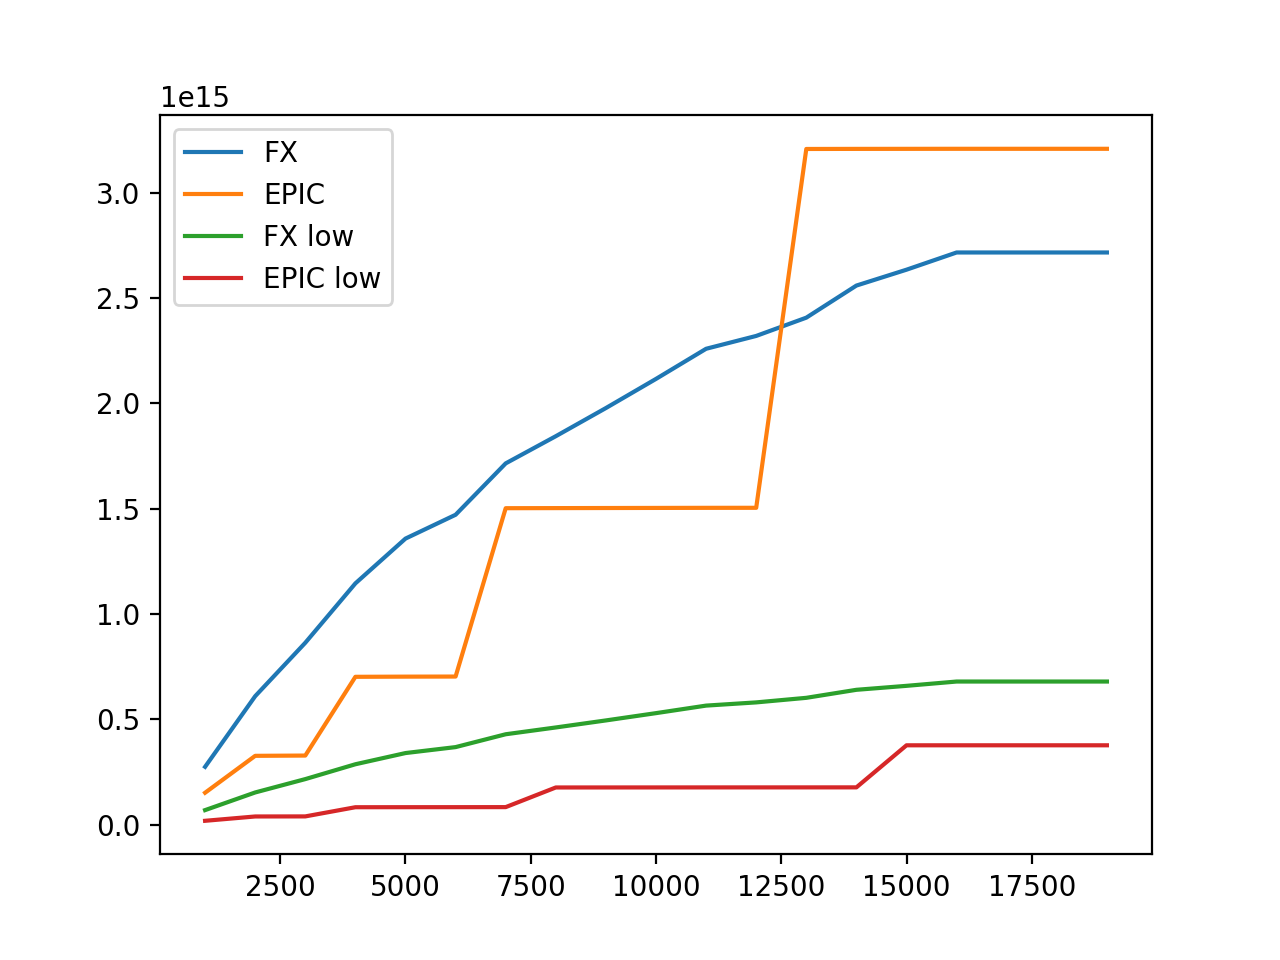

In [64]:
plt.figure()
plt.plot(np.arange(1000, 20000, 1000), FX_cost, label='FX')
plt.plot(np.arange(1000, 20000, 1000), EPIC_cost, label='EPIC')
plt.plot(np.arange(1000, 20000, 1000), FX_low_cost, label='FX low')
plt.plot(np.arange(1000, 20000, 1000), EPIC_low_cost, label='EPIC low')
plt.legend()

In [57]:
dsa.lambda0

222068487407.40744